<a href="https://colab.research.google.com/github/yudam-J/BERT-Cascading-Classifier/blob/main/weightforlevel3onehot_focalLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Í∏∞Î≥∏ Î™®Îìà
import os
import sys
import json
import re
import urllib.request
from glob import glob
from collections import Counter
import importlib

# Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
import pandas as pd
import numpy as np

# ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

# Colab
from google.colab import drive

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# HuggingFace Transformers
from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW

# ÌèâÍ∞Ä Î∞è ÏßÄÌëú
from sklearn.metrics import (
    f1_score, roc_auc_score, recall_score,
    accuracy_score, precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# ÏßÑÌñâÎ∞î
from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.0f}'.format)
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-bf__mah_/kobert-tokenizer_859128f03d264130bcce934fb175b59c
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-bf__mah_/kobert-tokenizer_859128f03d264130bcce934fb175b59c
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done


In [ ]:
final_df = pd.read_csv('/content/final_df.csv', encoding = 'utf-8')

<ipython-input-2-030e149079be>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv('/content/final_df.csv', encoding = 'utf-8')


In [ ]:
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str).str.strip().str.replace(" ", "", regex=True)
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)

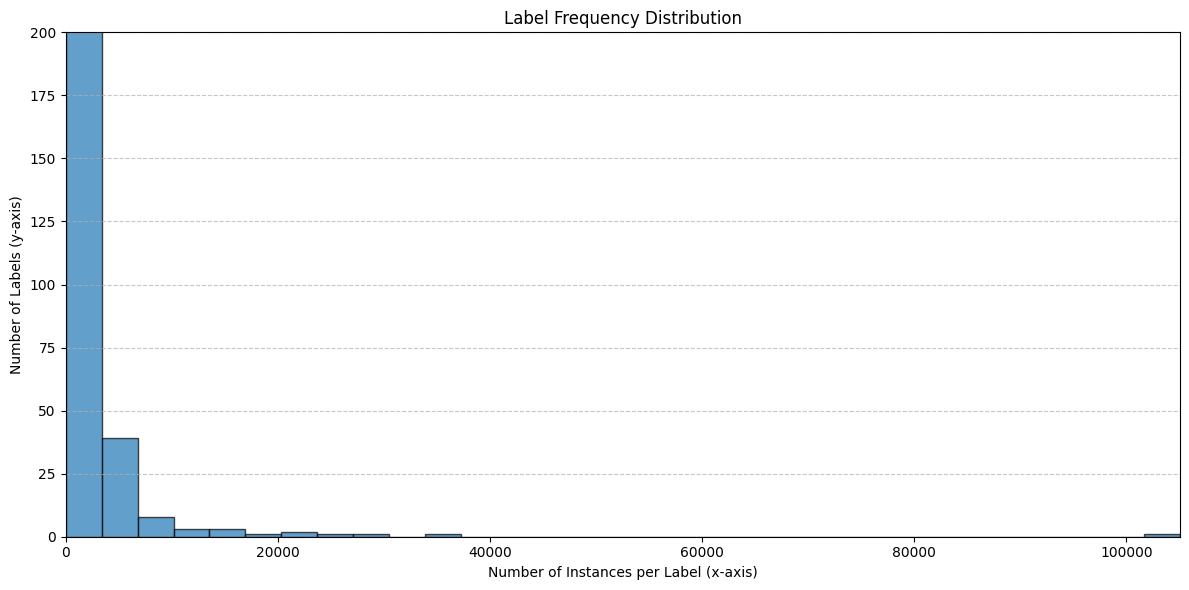

In [ ]:
# Í∞Å ÎùºÎ≤®Ïùò ÎπàÎèÑÏàò Í≥ÑÏÇ∞
label_counts = Counter(final_df['KDC_NM'])

# ÎùºÎ≤®Ïùò ÎπàÎèÑÏàò (xÏ∂ïÏóê Ìï¥Îãπ)
label_frequencies = list(label_counts.values())

# Ï†ÅÏ†àÌïú bin Í∞úÏàò Í≤∞Ï†ï (ÎπàÎèÑÏàòÏùò Î∂ÑÌè¨Î•º Í∏∞Ï§ÄÏúºÎ°ú)
n_bins = int(np.sqrt(len(label_frequencies)))  # ÎπàÎèÑÏàòÏóê ÎåÄÌï¥ Ï†úÍ≥±Í∑º Î≤ïÏπô Ï†ÅÏö©

# ÎùºÎ≤® ÎπàÎèÑÏàòÎ°ú ÌûàÏä§ÌÜ†Í∑∏Îû® Íµ¨Í∞Ñ ÏÑ§Ï†ï
plt.figure(figsize=(12, 6))

# ÌûàÏä§ÌÜ†Í∑∏Îû® Í∑∏Î¶¨Í∏∞
plt.hist(
    label_frequencies,  # ÎùºÎ≤® ÎπàÎèÑÏàò ÏÇ¨Ïö©
    bins=n_bins,  # ÎèôÏ†ÅÏúºÎ°ú Í≥ÑÏÇ∞Îêú bin Í∞úÏàò
    edgecolor='black',
    alpha=0.7
)

# xÏ∂ï ÏµúÎåÄÍ∞íÏùÑ label_frequenciesÏùò ÏµúÎåìÍ∞íÏúºÎ°ú ÏÑ§Ï†ï
plt.xlim(0, max(label_frequencies))
plt.ylim(0, 200)

# Í∑∏ÎûòÌîÑ ÏÑ§Ï†ï
plt.title('Label Frequency Distribution')
plt.xlabel('Number of Instances per Label (x-axis)')
plt.ylabel('Number of Labels (y-axis)')

# xÏ∂ïÏóê ÎùºÎ≤® ÎπàÎèÑÏàò ÌëúÏãú, yÏ∂ïÏóêÎäî Î†àÏù¥Î∏î Í∞úÏàò ÌëúÏãú
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Î†àÏù¥ÏïÑÏõÉ Ï°∞Ï†ï
plt.show()

In [ ]:
# Í∞Å Í≥†Ïú† ÎùºÎ≤®Ïùò Í∞úÏàò ÏÑ∏Í∏∞
label_counts = final_df['KDC_NM'].value_counts()

# ÌèâÍ∑†, ÏµúÎåÄ, ÏµúÏÜå, Ï§ëÍ∞ÑÍ∞í Íµ¨ÌïòÍ∏∞
mean_count = label_counts.mean()
max_count = label_counts.max()
min_count = label_counts.min()
median_count = label_counts.median()  # Ï§ëÍ∞ÑÍ∞í Í≥ÑÏÇ∞

# Í≤∞Í≥º Ï∂úÎ†•
print(f"ÎùºÎ≤® Í∞úÏàòÏùò ÌèâÍ∑†: {mean_count}")
print(f"ÎùºÎ≤® Í∞úÏàòÏùò ÏµúÎåÄÍ∞í: {max_count}")
print(f"ÎùºÎ≤® Í∞úÏàòÏùò ÏµúÏÜåÍ∞í: {min_count}")
print(f"ÎùºÎ≤® Í∞úÏàòÏùò Ï§ëÍ∞ÑÍ∞í: {median_count}")

ÎùºÎ≤® Í∞úÏàòÏùò ÌèâÍ∑†: 917.074
ÎùºÎ≤® Í∞úÏàòÏùò ÏµúÎåÄÍ∞í: 105047
ÎùºÎ≤® Í∞úÏàòÏùò ÏµúÏÜåÍ∞í: 1
ÎùºÎ≤® Í∞úÏàòÏùò Ï§ëÍ∞ÑÍ∞í: 83.0


In [ ]:
final_df.shape

(917074, 4)

In [ ]:
final_df.head()

TITLE_NM ISBN_THIRTEEN_NO KDC_NM  \
0             Î∞ò Í≥†Ìùê    9788988950050    651   
1      ÏùòÏÇ¨Í≤∞Ï†ï Î∂àÎ≥ÄÏùò Î≤ïÏπô    9788958610038    325   
2  Í≥µÏ£ºÎ•º ÌÇ§ÏõåÏ£ºÎäî ÌöåÏÇ¨Îäî ÏóÜÎã§    9788982736964    325   
3         Ï§ëÍµ≠Ïùò Ï†ú4Î¨ºÍ≤∞    9788947524223    341   
4  (Í≥µÎ≥ëÌò∏Ïùò)10ÎÖÑ ÌõÑ, ÏÑ∏Í≥Ñ    9788973376414    321   

                                         description  
0  Ïñ¥Î¶∞Ïù¥Îì§ÏùÑ ÏúÑÌïú ÏÑúÏñëÎØ∏Ïà† ÏûÖÎ¨∏ÏÑú 'ÌôîÍ∞ÄÏùò ÎßàÏùÑ' ÏãúÎ¶¨Ï¶à 3Í∂å. Î≤®Í∏∞ÏóêÏùò Ïπ¥Ïä§ÌÖåÎ•¥Îßù(...  
1  ÏùòÏÇ¨Í≤∞Ï†ïÏóê ÎåÄÌïú Ï†ÑÎûµÏÑú. ÏùºÏÉÅÏÉùÌôú ÏÜçÏóêÏÑú ÏùºÏñ¥ÎÇòÎäî Îã§ÏñëÌïú Ïã§Ï†ú ÏÇ¨Î°ÄÎ•º ÌÜµÌï¥ Ïù∏Í∞ÑÏù¥ ...  
2  Í∞ÑÎã®ÌïòÍ≤å ÎßêÌï¥ÏÑú Ïù¥ Ï±ÖÏùÄ Ïö∞ÏÑ† ÏßÅÏû•ÏóêÏÑú ÏÇ¥ÏïÑÎÇ®Í≥† Í∑∏ Îã§ÏùåÏóê ÏÑ±Í≥µÏúºÎ°ú Í∞ÄÎäî Î∞©Î≤ïÏùÑ Ïïå...  
3  13Ïñµ Ï§ëÍµ≠ÏùÑ Ïù¥ÎÅåÏñ¥Í∞à ÌõÑÏßÑÌÉÄÏò§ÏôÄ 4ÏÑ∏ÎåÄ ÏßÄÎèÑÏûê Ïö∞Î∞©Í∂à Ï†ÑÏù∏ÎåÄ ÏÉÅÎ¨¥ÏúÑÏõêÏû•, ÏôÑÏûêÎ∞îÏò§...  
4  ÏúºÎ°ú ÌïúÍµ≠ÏÇ¨ÌöåÏùò Î≥ÄÌôîÏùò ÌïÑÏöîÏÑ±ÏùÑ Ïó≠ÏÑ§ÌïòÎ©∞ ÌÅ∞ Î∞òÌñ•ÏùÑ Î∂àÎü¨ÏùºÏúºÏº∞Îçò Í≥µÎ≥ëÌò∏ Î∞ïÏÇ¨, Í∑∏Îäî...

In [ ]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 202
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
GRAD_ACCUMULATION_STEPS = 4
NUM_EPOCHS = 10
PATIENCE = 3  # early stopping Í∏∞Ï§Ä

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


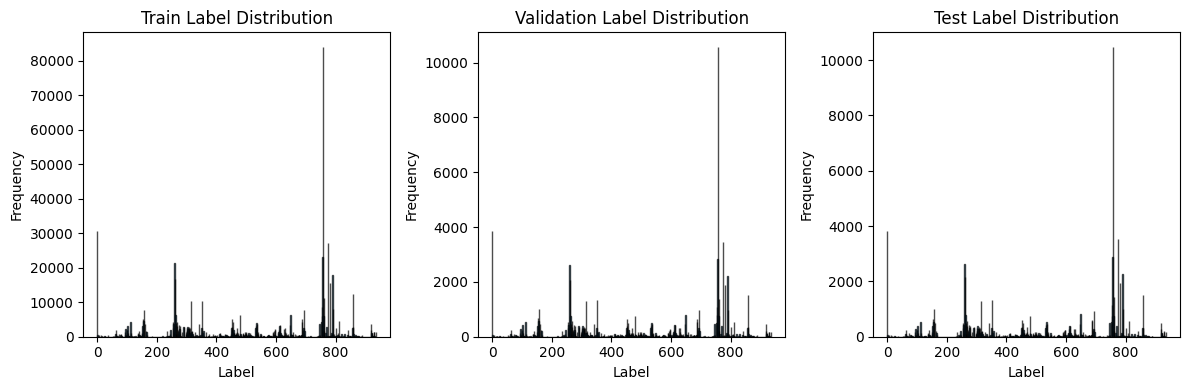

In [ ]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÏùò
class BookDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, label_dicts):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_dicts = label_dicts

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        input_text = item['TITLE_NM'] + " " + item['description']
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        labels = {
            'level1': self.label_dicts['level1'].get(str(item['level1']), 0),
            'level2': self.label_dicts['level2'].get(str(item['level2']), 0),
            'level3': self.label_dicts['level3'].get(str(item['level3']), 0)
        }

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels
        }


# Î™®Îç∏ Ï†ïÏùò
class CascadingBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(CascadingBERTClassifier, self).__init__()
        self.bert = bert_model
        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_classes['level1'])
        self.fc2 = nn.Linear(self.bert.config.hidden_size + num_classes['level1'], num_classes['level2'])
        self.fc3 = nn.Linear(self.bert.config.hidden_size + num_classes['level2'], num_classes['level3'])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]

        # level 1
        level1_logits = self.fc1(cls_output)
        level1_soft = F.softmax(level1_logits, dim=-1)  # üîÅ soft prediction ÏÇ¨Ïö©

        # level 2
        level2_input = torch.cat([cls_output, level1_soft], dim=-1)
        level2_logits = self.fc2(level2_input)
        level2_soft = F.softmax(level2_logits, dim=-1)

        # level 3
        level3_input = torch.cat([cls_output, level2_soft], dim=-1)
        level3_logits = self.fc3(level3_input)

        return level1_logits, level2_logits, level3_logits

# KDC ÏΩîÎìú Î†àÎ≤® Î∂ÑÌï¥
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)
final_df["level1"] = final_df["KDC_NM"].apply(lambda x: x[:1] + "00" if len(x) >= 1 else "000")
final_df["level2"] = final_df["KDC_NM"].apply(lambda x: x[:2] + "0" if len(x) >= 2 else "000")
final_df["level3"] = final_df["KDC_NM"].apply(lambda x: x if len(x) >= 3 else "000")

# Î†àÏù¥Î∏î ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
label_dicts = {
    level: {str(k): v for v, k in enumerate(sorted(final_df[level].unique()))}
    for level in ['level1', 'level2', 'level3']
}

# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î∞è Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1")
dataset = BookDataset(final_df, tokenizer, MAX_LENGTH, label_dicts)

# ÌïôÏäµ/Í≤ÄÏ¶ù/ÌÖåÏä§Ìä∏ Î∂ÑÌï†
indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# ÎùºÎ≤® Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
def plot_label_distribution(train_labels, val_labels, test_labels):
    plt.figure(figsize=(12, 4))
    for i, (labels, title) in enumerate(zip(
        [train_labels, val_labels, test_labels],
        ['Train Label Distribution', 'Validation Label Distribution', 'Test Label Distribution']
    )):
        plt.subplot(1, 3, i+1)
        plt.hist(labels, bins=np.arange(min(labels), max(labels)+1, 1), edgecolor='black', alpha=0.7)
        plt.title(title)
        plt.xlabel('Label')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

train_labels = [sample['labels']['level3'] for sample in train_dataset]
val_labels = [sample['labels']['level3'] for sample in val_dataset]
test_labels = [sample['labels']['level3'] for sample in test_dataset]
plot_label_distribution(train_labels, val_labels, test_labels)


# Loss Í≥ÑÏÇ∞ Ìï®Ïàò
def compute_loss(outputs, labels, loss_fns):
    label1 = labels['level1'].to(outputs[0].device)
    label2 = labels['level2'].to(outputs[1].device)
    label3 = labels['level3'].to(outputs[2].device)

    loss1 = loss_fns['level1'](outputs[0], label1)
    loss2 = loss_fns['level2'](outputs[1], label2)
    loss3 = loss_fns['level3'](outputs[2], label3)

    return loss1 + loss2 + loss3

# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
from collections import Counter

labels = dataset.data['level3'].astype(str).tolist()
label_counts = Counter([dataset.label_dicts['level3'].get(label, 0) for label in labels])

# ÌÅ¥ÎûòÏä§ Í∞úÏàò ÏàòÏ†ï
num_classes = len(label_dicts['level3'])
total_samples = sum(label_counts.values())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ (0.1Î°ú Í∏∞Î≥∏Í∞í ÏÑ§Ï†ïÌïòÏó¨ Ïò§Î•ò Î∞©ÏßÄ)
class_weights = [total_samples / (num_classes * label_counts.get(i, 0.1)) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn_level3 = nn.CrossEntropyLoss(weight=weights_level3)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalBCELoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalBCELoss, self).__init__()
        self.alpha = alpha  # shape: [num_classes] or float
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')  # shape: (B, C)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma

        if self.alpha is not None:
            alpha = self.alpha.to(logits.device)
            alpha_factor = torch.where(targets == 1, alpha, 1 - alpha)  # shape: (B, C)
            loss = alpha_factor * focal_term * ce_loss
        else:
            loss = focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
from torch.cuda.amp import autocast, GradScaler

# ÌïôÏäµ Ìï®Ïàò
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs, patience):
    scaler = GradScaler()
    model.to(device)
    best_val_loss = float("inf")
    early_stopping_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, corrects, total = 0, {"level1": 0, "level2": 0, "level3": 0}, 0

        train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for batch in train_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.to(device) for k, v in batch['labels'].items()}

            labels['level3'] = F.one_hot(labels['level3'], num_classes=num_classes['level3']).float()

            optimizer.zero_grad()

            with autocast():  # üî∏ Mixed Precision Ï†ÅÏö©
                outputs = model(input_ids, attention_mask)
                loss = compute_loss(outputs, labels, loss_fns)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            total += input_ids.size(0)

            for i, level in enumerate(corrects.keys()):
                preds = outputs[i].argmax(dim=-1)
                corrects[level] += (preds == labels[level]).sum().item()

            train_tqdm.set_postfix(loss=loss.item())

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(sum(corrects.values()) / (3 * total))

        val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered!")
                break

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


# ÌèâÍ∞Ä Ìï®Ïàò
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, corrects, total = 0, {"level1": 0, "level2": 0, "level3": 0}, 0
    val_tqdm = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.to(device) for k, v in batch['labels'].items()}

            # üîÅ one-hot Î≥ÄÌôò (loss Í≥ÑÏÇ∞Ïö©)
            labels_onehot = labels.copy()
            labels_onehot['level3'] = F.one_hot(labels['level3'], num_classes=num_classes['level3']).float()

            outputs = model(input_ids, attention_mask)
            loss = compute_loss(outputs, labels_onehot, loss_fn)
            total_loss += loss.item()
            total += input_ids.size(0)

            for i, level in enumerate(corrects.keys()):
                preds = outputs[i].argmax(dim=-1)
                # ÎπÑÍµêÎäî Ï†ïÎãµ ÏõêÎûò Í∞í(labels) Í∏∞Ï§Ä
                corrects[level] += (preds == labels[level]).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = sum(corrects.values()) / (3 * total)
    return avg_loss, avg_accuracy

# ÌÖåÏä§Ìä∏ ÌèâÍ∞Ä Ìï®Ïàò
def test_model(model, test_loader, device):
    model.eval()
    all_preds = {"level1": [], "level2": [], "level3": []}
    all_labels = {"level1": [], "level2": [], "level3": []}

    test_tqdm = tqdm(test_loader, desc="Testing", leave=False)

    with torch.no_grad():
        for batch in test_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.cpu().numpy() for k, v in batch['labels'].items()}  # Ï†ïÏàòÌòï Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ

            outputs = model(input_ids, attention_mask)
            preds = {level: outputs[i].argmax(dim=-1).cpu().numpy() for i, level in enumerate(all_preds.keys())}

            for level in all_preds:
                all_preds[level].extend(preds[level])
                all_labels[level].extend(labels[level])

    return evaluate_test_metrics(all_preds, all_labels)

# ÌÖåÏä§Ìä∏ Î©îÌä∏Î¶≠ Ï∂úÎ†•
def evaluate_test_metrics(all_preds, all_labels):
    metrics = {}
    for level in all_preds:
        metrics[level] = {
            "Accuracy": accuracy_score(all_labels[level], all_preds[level]),
            "Micro F1": f1_score(all_labels[level], all_preds[level], average="micro"),
            "Macro F1": f1_score(all_labels[level], all_preds[level], average="macro"),
            "Micro Precision": precision_score(all_labels[level], all_preds[level], average="micro"),
            "Macro Precision": precision_score(all_labels[level], all_preds[level], average="macro"),
            "Micro Recall": recall_score(all_labels[level], all_preds[level], average="micro"),
            "Macro Recall": recall_score(all_labels[level], all_preds[level], average="macro")
        }

    print("\nTest Performance:")
    for level, results in metrics.items():
        print(f" - {level}:")
        for metric, value in results.items():
            print(f"   {metric}: {value:.4f}")
    return metrics


# ÌïôÏäµ ÏãúÍ∞ÅÌôî Ìï®Ïàò
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(val_losses, label="Val Loss", marker="o")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc", marker="o")
    plt.plot(val_accs, label="Val Acc", marker="o")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
bert_model = AutoModel.from_pretrained("skt/kobert-base-v1")
num_classes = {
    'level1': len(label_dicts['level1']),
    'level2': len(label_dicts['level2']),
    'level3': len(label_dicts['level3']),
}

# class_weights_tensor: shape = [num_level3_classes]
# Í∏∞Ï°¥Ïóê inverse frequency Í∏∞Î∞òÏúºÎ°ú ÎßåÎì§Ïñ¥Ï°åÎã§Î©¥
alpha = class_weights_tensor.float()  # ÌòπÏãú LongTensorÏùº ÏàòÎèÑ ÏûàÏúºÎãà float Î≥ÄÌôò
alpha = alpha / alpha.sum()  # Ï†ïÍ∑úÌôî (Ìï©Ïù¥ 1)
model = CascadingBERTClassifier(bert_model, num_classes)

loss_fns = {
    "level1": nn.CrossEntropyLoss(),                      # ÏùºÎ∞ò CrossEntropy
    "level2": nn.CrossEntropyLoss(),                      # ÏùºÎ∞ò CrossEntropy
    "level3": FocalBCELoss(alpha=alpha, gamma=2.0)  # <- focal BCE Ï†ÅÏö©
}

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fns,
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)


model.load_state_dict(torch.load("best_model.pt"))
test_metrics = test_model(model, test_loader, Device)

<ipython-input-12-cdf966436295>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/5 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

<ipython-input-12-cdf966436295>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # üî∏ Mixed Precision Ï†ÅÏö©


Validating:   0%|          | 0/2866 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 11.8480, Train Acc: 0.2394
Epoch 1/5 - Val Loss: 10.7701, Val Acc: 0.3098


Epoch 2/5 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 10.1647, Train Acc: 0.3361
Epoch 2/5 - Val Loss: 9.6265, Val Acc: 0.3707


Epoch 3/5 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

In [ ]:
# 1. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î∂àÎü¨Ïò§Í∏∞
checkpoint = torch.load("/content/onehot_epoch2.pt", map_location=DEVICE)

# 2. Ï†ÄÏû•Îêú Ï†ïÎ≥¥ Ï∂îÏ∂ú
label_dicts = checkpoint["label_dicts"]
args = checkpoint["args"]

# 3. Î™®Îç∏ Ïû¨Íµ¨ÏÑ± Î∞è Í∞ÄÏ§ëÏπò Î°úÎìú
bert_model = AutoModel.from_pretrained("skt/kobert-base-v1")
model = CascadingBERTClassifier(bert_model, args["num_classes"])
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE)

print("‚úÖ Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å.")

# 4. ÏòµÌã∞ÎßàÏù¥Ï†Ä Îã§Ïãú Ï†ïÏùò (ÏÉàÎ°úÏö¥ ÌïôÏäµÎ•† ÏÑ§Ï†ï Í∞ÄÎä•)
optimizer = AdamW(model.parameters(), lr=2e-5)

# 5. Ï∂îÍ∞Ä ÌïôÏäµ ÏãúÏûë
NUM_EPOCHS = 8       # Ï∂îÍ∞Ä ÌïôÏäµ ÏóêÌè≠ Ïàò
PATIENCE = 2         # ÏñºÎ¶¨ Ïä§ÌÜ±Ìïë Í∏∞Ï§Ä

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fns,
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)

# 6. Í∞ÄÏû• ÏÑ±Îä• Ï¢ãÏïòÎçò Î™®Îç∏ Îã§Ïãú Î°úÎìú (early stoppingÏóê ÏùòÌï¥ Ï†ÄÏû•Îêú best_model.pt)
model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
model.to(DEVICE)
print("\n‚úÖ ÌÖåÏä§Ìä∏ Ï†Ñ ÏµúÏ†Å Î™®Îç∏ Î°úÎìú ÏôÑÎ£å.")

# 7. ÌÖåÏä§Ìä∏ ÏàòÌñâ
test_metrics = test_model(model, test_loader, DEVICE)


In [ ]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing for Confusion Matrix"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']['level3'].to(device)

        # autocastÎäî AMP ÌôòÍ≤ΩÏóêÏÑúÎßå ÏÇ¨Ïö© (ÏÑ†Ïñ∏ Ïïà ÎêòÏñ¥ ÏûàÎã§Î©¥ ÏÉùÎûµ Í∞ÄÎä•)
        # with autocast():
        _, _, logits = model(input_ids, attention_mask)

        preds = torch.argmax(logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion Matrix ÏÉùÏÑ±
conf_matrix = confusion_matrix(all_labels, all_preds)

# ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ Ï†ïÎ†¨ (level3 Í∏∞Ï§Ä)
class_names = [k for k, _ in sorted(label_dicts['level3'].items(), key=lambda x: x[1])]

# ÏãúÍ∞ÅÌôî
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=90)
plt.title("Confusion Matrix (Level 3)")
plt.tight_layout()
plt.show()

In [ ]:
misclassified_pairs = list(zip(*top_misclassifications))
misclassified_pairs = sorted(
    misclassified_pairs,
    key=lambda pair: error_matrix[pair[0], pair[1]],
    reverse=True
)

for true_class, pred_class in misclassified_pairs:
    count = error_matrix[true_class, pred_class]
    if count > 0:
        print(f"True: {class_names[true_class]}, Predicted: {class_names[pred_class]}, Count: {count}")